# STEP 1 : 시계열 데이터 준비


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA




dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()




Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
    1.결측치 처리
    2.로그 반환

In [9]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [10]:
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석

In [11]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()   # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()     # 이동표준편차 시계열
# 원본시계열, 이동평균, 이동표준편차를 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [19]:
# statsmodels 패키지에서 제공하는 adfuller 메소드 호출
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


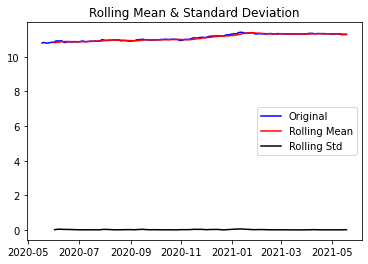

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


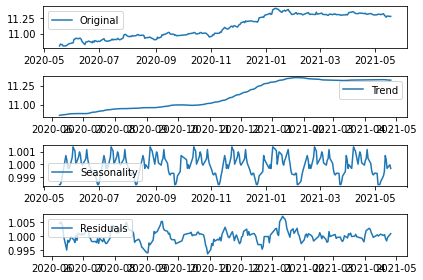

In [13]:

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [14]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

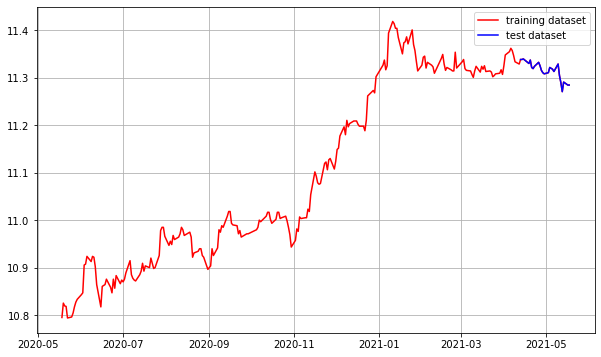

In [15]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
1. ACF, PACF 그려보기 -> p,q 구하기
2. 차분 안정성 확인 -> d 구하기

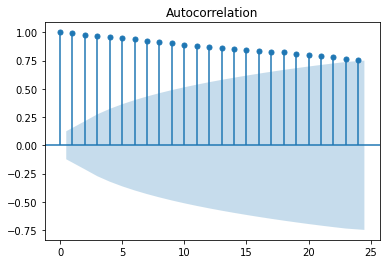

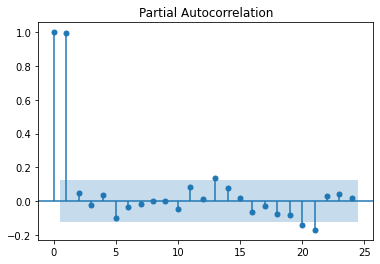

In [16]:


plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


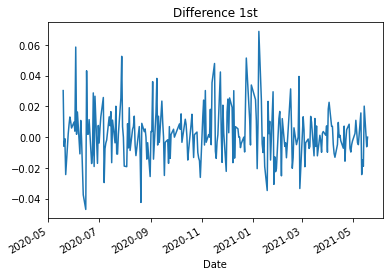

In [17]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


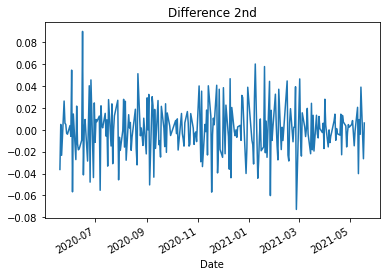

In [18]:
#  2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트
1.ARIMA 모델 빌드와 훈련

2.모델 테스트 및 플로팅

3.최종 예측 모델 정확도 측정(MAPE)


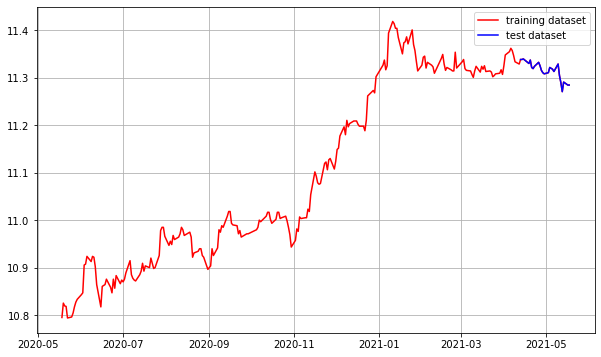

In [21]:
#학습데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [22]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


In [23]:
import warnings
warnings.filterwarnings("ignore")

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())  

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 15 Nov 2021   AIC                          -1164.792
Time:                        07:44:33   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

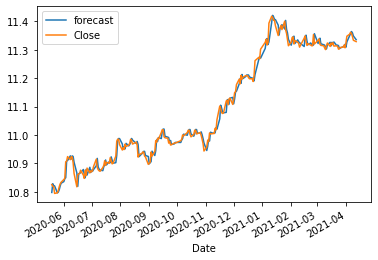

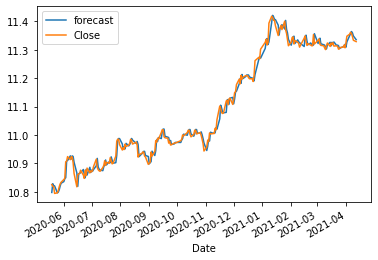

In [24]:
fitted_m.plot_predict()

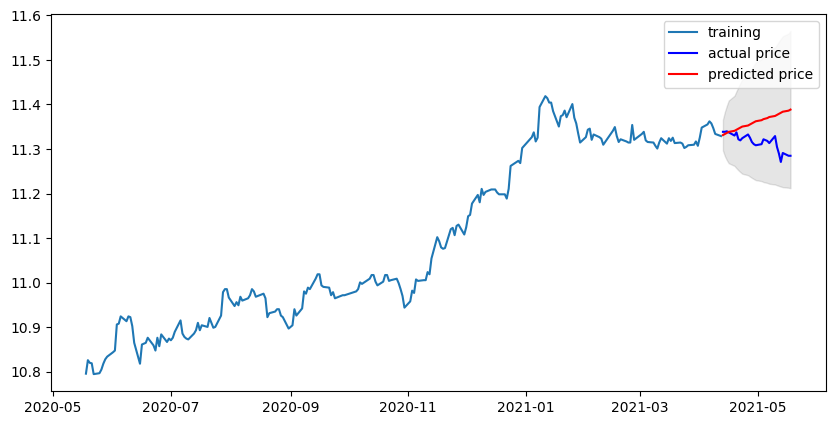

In [25]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()




In [27]:
#최종 오차율을 계산하기 위해서 로그로 변환 했던 것을 지수로 돌려줌
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


4.68% 의 오차율이 나왔다 오차율을 줄이기 위해서 더 적당한 모수찾기를 해봐야 한다. 


# STEP 7 : 다른 주식 종목 예측해 보기

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMZN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_amzn = df['Close']

ts_amzn.head()

Date
2020-11-16    3131.060059
2020-11-17    3135.659912
2020-11-18    3105.459961
2020-11-19    3117.020020
2020-11-20    3099.399902
Name: Close, dtype: float64

In [40]:
ts_amzn=ts_amzn.interpolate(method='time')
ts_amzn[ts_amzn.isna()]

Series([], Name: Close, dtype: float64)

In [41]:
ts_amzn_log = np.log(ts_amzn)

In [42]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [43]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

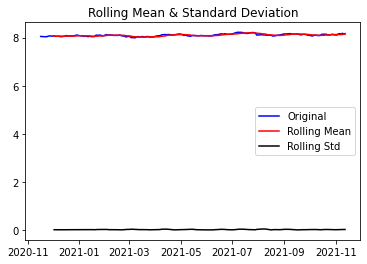

Results of Dickey-Fuller Test:
Test Statistic                  -2.638369
p-value                          0.085324
#Lags Used                       1.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


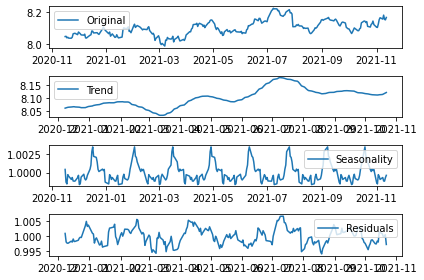

In [44]:
plot_rolling_statistics(ts_amzn_log, window=12)

augmented_dickey_fuller_test(ts_amzn_log)

decomposition = seasonal_decompose(ts_amzn_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_amzn_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [45]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.053823
p-value                          0.000017
#Lags Used                       1.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


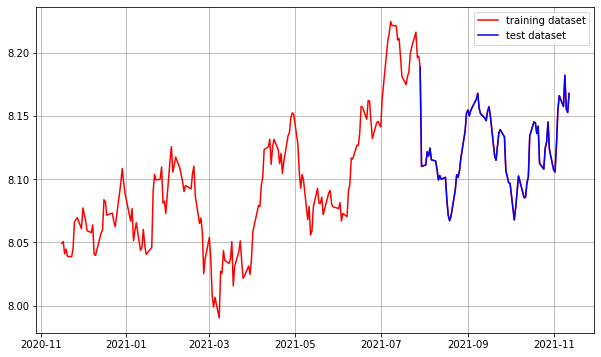

In [46]:
train_data, test_data = ts_amzn_log[:int(len(ts_amzn_log)*0.7)], ts_amzn_log[int(len(ts_amzn_log)*0.7):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_amzn_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

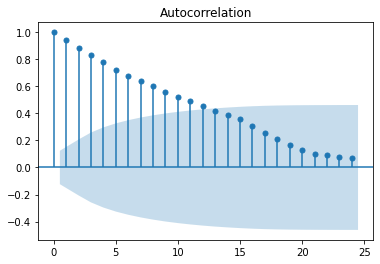

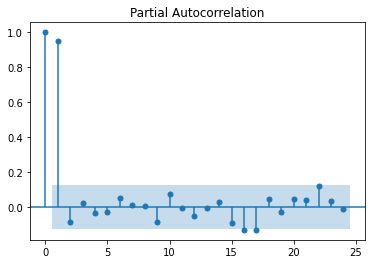

In [47]:
#arima
plot_acf(ts_amzn_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_amzn_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.455378e+01
p-value                        4.918530e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


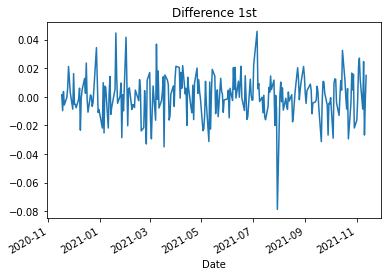

In [48]:
diff_1 = ts_amzn_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.004712e+00
p-value                        2.284042e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


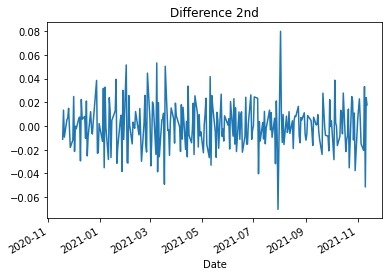

In [49]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -8.004712e+00
p-value                        2.284042e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


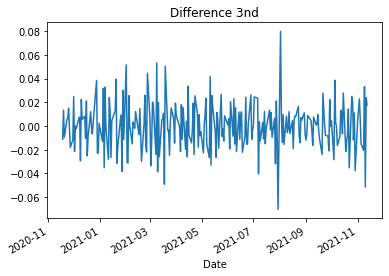

In [50]:
diff_3 = diff_1.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3nd')

augmented_dickey_fuller_test(diff_3)

In [57]:
#from pmdarima.arima import auto_arima

#auto_arima_model = auto_arima(train_data, start_p = 0, start_q=0, trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)
#from pmdarima.arima import auto_arima
!pip install pmdarima
from pmdarima.arima import auto_arima

model_arima= auto_arima(train_data,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)

model_arima.fit(train_data)


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-981.238, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-979.409, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-977.880, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-976.418, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-979.389, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-977.505, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-975.891, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-974.943, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-978.033, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-975.989, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-974.662, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-975.347, Time=1.58 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-976.097, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : A

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [65]:
# AIC(통계 모델 성능을 측정기준은 낮을수록 좋은 모델이다) 
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(0,1,0))

model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  174
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 492.619
Method:                           css   S.D. of innovations              0.014
Date:                Tue, 16 Nov 2021   AIC                           -981.238
Time:                        15:29:28   BIC                           -974.920
Sample:                             1   HQIC                          -978.675
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.786      0.432      -0.001       0.003


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

In [21]:
# #Train & Test
# model = ARIMA(train_data, order=(1, 1, 0))  
# fitted_m = model.fit(disp=-1)  
# print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  174
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 492.695
Method:                       css-mle   S.D. of innovations              0.014
Date:                Tue, 16 Nov 2021   AIC                           -979.389
Time:                        12:17:37   BIC                           -969.912
Sample:                             1   HQIC                          -975.545
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      0.764      0.445      -0.001       0.003
ar.L1.D.Close     0.0294      0.076      0.389      0.697      -0.119       0.178
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

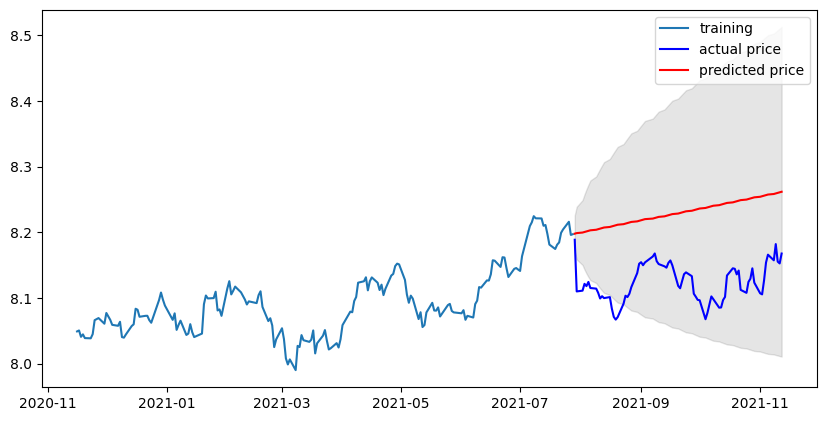

In [62]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index) 
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  154302.21302763134
MAE:  378.71478610023235
RMSE:  392.81320373382476
MAPE: 11.30%


# 결과
삼성과 아마존의 주식 예측을 해 보았다.
아마존의 MAPE: 11.30% 
결과를 보면 AIC는(낮을수록 좋음) 낮게 나왔지만 11.30% 의 오차율이 나왔다 오차율이 왜 높은건지 그래서 start_p, start_q, max_p, max_q 범위를 정해 보았다. start와 max의 범위를 설정해서 적절한 p,d,q 값을 찾을수 있을지 고민해 보았다. 하지만 오차율이 그대로 나왔다. 더 고민해 봐야겠다.
